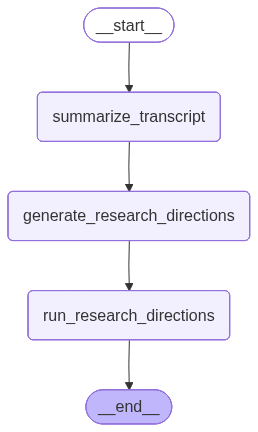

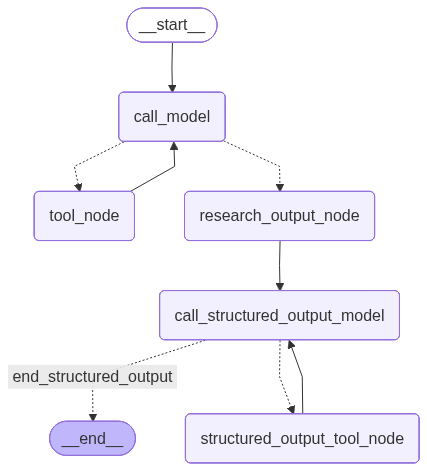

In [12]:
import os
import sys
import asyncio
import json
from uuid import uuid4
from pathlib import Path
from typing import Optional, List, Dict, Any, TypedDict, cast 

from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.state import CompiledStateGraph 
from langchain_core.runnables import RunnableConfig   
from graphql_client.async_base_client import AsyncBaseClient   
from urllib.parse import urlparse  
from tavily import AsyncTavilyClient 
from firecrawl import AsyncFirecrawl   
from langchain_community.tools import WikipediaQueryRun  
from langchain_community.utilities import WikipediaAPIWrapper  
from research_agent.research_subgraph import research_subgraph_builder, DirectionResearchResult, ResearchState  

import aiofiles

# Windows-specific: psycopg requires SelectorEventLoop, not ProactorEventLoop
if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

from research_agent.output_models import TranscriptSummaryOutput, ResearchDirectionOutput, ResearchDirection
from research_agent.prompts.prompts import summary_prompt, SUMMARY_SYSTEM_PROMPT


# -----------------------------------------------------------------------------
# Environment & Paths
# -----------------------------------------------------------------------------

load_dotenv()  

graphql_auth_token = os.getenv("GRAPHQL_AUTH_TOKEN")
graphql_url = os.getenv("GRAPHQL_LOCAL_URL")  # e.g., "http://localhost:4000/graphql" 

tavily_api_key = os.getenv("TAVILY_API_KEY")
firecrawl_api_key = os.getenv("FIRECRAWL_API_KEY") 

ncbi_api_key = os.getenv("NCBI_API_KEY") 

tavily_client = AsyncTavilyClient(api_key=tavily_api_key)
firecrawl_client = AsyncFirecrawl(api_key=firecrawl_api_key)

wikipedia_api_wrapper = WikipediaAPIWrapper( 
    top_k_results=4, 
    doc_content_chars_max=4000, 
) 

wiki_tool = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)   




# Load in Langsmith Versioned Prompts here  








# # Convert HTTP URL to WebSocket URL
# parsed = urlparse(graphql_url)
# ws_url = f"ws://{parsed.netloc}{parsed.path}"  # e.g., "ws://localhost:4000/graphql"

# async_graphql_client = AsyncBaseClient(
#     url=graphql_url,
#     ws_url=ws_url,  # Add this for WebSocket subscriptions
#     headers={"Authorization": f"Bearer {graphql_auth_token}"},
#     ws_headers={"Authorization": f"Bearer {graphql_auth_token}"},  # Auth for WebSocket too
# )

# Adjust this if your layout is different:
# Assuming: project_root/dev_env/... and this file in src/research_agent/ 

# Conceptually we want to 
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[2]  

PARENT_DIR = Path(os.getcwd()).resolve().parent   
DATA_DIR = PARENT_DIR / "dev_env" / "data"
OUTPUT_DIR = PARENT_DIR / "dev_env" / "summary_graph_outputs"

TRANSCRIPT_FILE = DATA_DIR / "full_transcript_two.txt"
WEBPAGE_SUMMARY_FILE = DATA_DIR / "webpage_summary_two.md"

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# -----------------------------------------------------------------------------
# Models for Web Search Output
# -----------------------------------------------------------------------------

class ProductSearchOutput(BaseModel):
    product_name: str = Field(..., description="The name of the product")
    product_overview: str = Field(..., description="A concise overview of the product")
    product_ingredients: List[str] = Field(..., description="The ingredients of the product")
    product_price: Optional[float] = Field(
        default=None,
        description="The price of the product",
    )
    product_url: Optional[str] = Field(
        default=None,
        description="The URL of the product",
    )


class BusinessSearchOutput(BaseModel):
    business_name: str = Field(..., description="The name of the business")
    business_overview: str = Field(..., description="A concise overview of the business")
    products: List[ProductSearchOutput] = Field(
        ...,
        description="The products of the business",
    )


class WebSearchOutput(BaseModel):
    guest_name: str = Field(..., description="The name of the guest")
    guest_overview: str = Field(..., description="A concise overview of the guest")
    business: BusinessSearchOutput = Field(
        ...,
        description="The business of the guest",
    )
    research_complete: bool = Field(
        ...,
        description="Whether the research is complete",
    )



# -----------------------------------------------------------------------------
# LangChain Models
# -----------------------------------------------------------------------------

summary_model = ChatOpenAI(
    model="gpt-5-nano",
    reasoning_effort="medium",
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
)

web_search_model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
) 

general_model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
) 

openai_search_tool = {"type": "web_search"}  # passed into create_agent tools 




# -----------------------------------------------------------------------------
# Guest Search Prompt Template
# -----------------------------------------------------------------------------

GUEST_SEARCH_PROMPT = """
Your task is to gather accurate, up-to-date information about the following guest who appeared on 
The Human Upgrade podcast with Dave Asprey.

Guest Name:
{guest_name}

Guest Description:
{guest_description}

Guest Company or Affiliation:
{guest_company}

Guest Product or Offering:
{guest_product_affiliation}

Your job is to:
1. Conduct thorough web research using your available web search tool.
2. Validate the guest’s identity, background, profession, and reputation.
3. Identify their primary business, company, or organization.
4. Identify the products, programs, supplements, or technologies associated with them.
5. Collect concise but complete information suitable for a biotech knowledge system focused on 
   human longevity, performance, and excellence.
6. When you have gathered enough information to confidently populate:
   - guest_name
   - guest_overview
   - business (name, overview, product details)
   - product specifics (ingredients, pricing, URLs, etc.)
   then set the `research_complete` flag to True.

If more information is still needed, set `research_complete` to False and request additional refinement or 
additional search passes.

Ensure every response is factual, verifiable, and grounded in real web data.
"""


# -----------------------------------------------------------------------------
# Graph State Definition
# -----------------------------------------------------------------------------

class TranscriptGraph(TypedDict, total=False):
    episode_meta: Dict[str, Any]
    webpage_summary: str
    full_transcript: str 
    initial_transcript_output: TranscriptSummaryOutput  
    research_directions: List[ResearchDirection]

    # outputs of the per-direction subgraphs
    direction_results: List[DirectionResearchResult]
    direction_structured_outputs: List[BaseModel]

   


# -----------------------------------------------------------------------------
# Filesystem Helpers
# -----------------------------------------------------------------------------

async def write_summary_outputs_without_docs(
    summary_output: TranscriptSummaryOutput,
    output_dir: Path,
    episode_number: int,
) -> None:
    output_dir.mkdir(parents=True, exist_ok=True)

    summary_path = output_dir / f"episode_{episode_number}_summary.txt"
    guest_path = output_dir / f"episode_{episode_number}_guest.json"

    async with aiofiles.open(summary_path, "w", encoding="utf-8") as f:
        await f.write(summary_output.summary)

    async with aiofiles.open(guest_path, "w", encoding="utf-8") as f:
        await f.write(summary_output.guest_information.model_dump_json(indent=2))

    print(f"Finished writing summary outputs for episode {episode_number}")


async def write_guest_research_outputs(
    web_output: WebSearchOutput,
    history: List[WebSearchOutput],
    output_dir: Path,
    episode_number: int,
) -> None:
    output_dir.mkdir(parents=True, exist_ok=True)

    research_path = output_dir / f"episode_{episode_number}_guest_research.json"
    history_path = output_dir / f"episode_{episode_number}_guest_research_history.json"

    async with aiofiles.open(research_path, "w", encoding="utf-8") as f:
        await f.write(web_output.model_dump_json(indent=2))

    async with aiofiles.open(history_path, "w", encoding="utf-8") as f:
        await f.write(json.dumps(
            [item.model_dump() for item in history],
            indent=2
        ))

    print(f"Finished writing guest research outputs for episode {episode_number}")


# -----------------------------------------------------------------------------
# Graph Nodes
# -----------------------------------------------------------------------------

async def summarize_transcript(state: TranscriptGraph) -> TranscriptGraph:
    summary_agent = create_agent(
        summary_model,
        system_prompt=SUMMARY_SYSTEM_PROMPT,
        response_format=TranscriptSummaryOutput,
    )

    webpage_summary = state.get("webpage_summary")
    full_transcript = state.get("full_transcript")

    if not webpage_summary or not full_transcript:
        raise RuntimeError("webpage_summary and full_transcript are required for this graph")

    formatted_summary_prompt = summary_prompt.format(
        webpage_summary=webpage_summary,
        full_transcript=full_transcript,
    )

    summary_agent_response = await summary_agent.ainvoke(
        {"messages": [{"role": "user", "content": formatted_summary_prompt}]}
    )

    transcript_output: TranscriptSummaryOutput = summary_agent_response["structured_response"]

    episode_number = state["episode_meta"]["episode_number"]
    await write_summary_outputs_without_docs(
        summary_output=transcript_output,
        output_dir=OUTPUT_DIR,
        episode_number=episode_number,
    )

    # Return partial state update (LangGraph merges this into the state)
    return {"initial_transcript_output": transcript_output}


research_subgraph: "CompiledStateGraph" = research_subgraph_builder.compile() 

async def run_research_directions(state: TranscriptGraph) -> TranscriptGraph:
    """
    For each ResearchDirection in the episode, run the research_subgraph and
    aggregate the results back onto the TranscriptGraph state.
    """
    directions: List[ResearchDirection] = state.get("research_directions", []) or []

    if not directions:
        # Nothing to do; return state unchanged
        return {
            "direction_results": [],
            "direction_structured_outputs": [],
        }

    episode_context = ""
    if state.get("initial_transcript_output") is not None:
        # whatever your summary field is called:
        episode_context = getattr(
            state["initial_transcript_output"], "summary", ""
        ) or ""

    all_direction_results: List[DirectionResearchResult] = []
    all_structured_outputs: List[BaseModel] = []

    # Run subgraph once per direction (sequentially).
    # You can later add bounded concurrency here with asyncio.gather if needed.
    for direction in directions:
        initial_child_state: ResearchState = {
            "messages": [],
            "llm_calls": 0,
            "tool_calls": 0,
            "direction": direction,
            "episode_context": episode_context,
            "research_notes": [],
            "citations": [],
            "steps_taken": 0,
            "structured_outputs": [],
        }

        child_final: ResearchState = cast(
            ResearchState,
            await research_subgraph.ainvoke(initial_child_state),
        )

        # pull out the master result for this direction
        if "result" in child_final and child_final["result"] is not None:
            all_direction_results.append(child_final["result"])

        # merge any entities created
        if "structured_outputs" in child_final and child_final["structured_outputs"]:
            all_structured_outputs.extend(child_final["structured_outputs"])

    return {
        "direction_results": all_direction_results,
        "direction_structured_outputs": all_structured_outputs,
    }


async def generate_research_directions(state: TranscriptGraph) -> TranscriptGraph:  

    initial_transcript_output_summary = state.get("initial_transcript_output").summary 

    if not initial_transcript_output_summary:
        raise Exception("Missing the necessary summary to continue the research directions")

    

    # Fetch memories related to previous runs 

    research_directions_prompt = f"""
    You are a critical piece in the research process for a biotech information system built in collaboration 
    with Dave Asprey. Currently the organization is enriching the knowledge base that contains each of the guests 
    that have come on the show with Dave Asprey. Utilize your web search tool to find up to date information about 
    the guest, their business, business affiliations and those business products. When you have found all of the 
    information you need ensure you respond with the research_directions field set to True 
    
    {initial_transcript_output_summary}.
    """  

    research_directions_prompt_template = PromptTemplate.from_template(research_directions_prompt)    


    research_directions_agent = create_agent( 
        general_model, 
        system_prompt=research_directions_prompt,
        response_format=ResearchDirectionOutput, 
    
    )  

    research_directions_response = await research_directions_agent.ainvoke({"messages": [{"role": "user", "content": research_directions_prompt_template}]})
    research_directions_output: ResearchDirectionOutput = research_directions_response["structured_response"]

    return {
        "research_directions": research_directions_output.research_directions,
    }



# Guest Output should go to subgraph with wikipedia tool in addition to firecrawl and tavily or just go to another node in this graph 
# for guest output 
# Or guest output is part of Research Directions 

# -----------------------------------------------------------------------------
# Build the Graph
# -----------------------------------------------------------------------------

graph = StateGraph(TranscriptGraph)

graph.add_node("summarize_transcript", summarize_transcript) 
graph.add_node("generate_research_directions", generate_research_directions)  
graph.add_node("run_research_directions", run_research_directions)   



graph.add_edge(START, "summarize_transcript") 
graph.add_edge("summarize_transcript", "generate_research_directions")   
graph.add_edge("generate_research_directions", "run_research_directions")    

graph.add_edge("run_research_directions", END)  

# Generates a List of Research Directions how map out the subgraph or whatever operation strategy 

# Compile without checkpointer for langgraph dev server compatibility
# The dev server will inject its own in-memory checkpointer
app: CompiledStateGraph = graph.compile()   


from IPython.display import Image, display 

display(Image(app.get_graph().draw_mermaid_png()) ) 

display(Image(research_subgraph.get_graph().draw_mermaid_png()) )
